In [1]:
%load_ext pycodestyle_magic
%flake8_on
# PEP8 tested

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from itertools import product, combinations
from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from umap import UMAP
import time
%matplotlib inline

7:80: E501 line too long (98 > 79 characters)
8:80: E501 line too long (92 > 79 characters)
1: E999 SyntaxError: invalid syntax


In [3]:
# be sure to display any columns
pd.options.display.max_columns = 100

# Read data

In [4]:
# read data
time_start = time.time()
data = pd.read_csv('Data/data.csv')
print('data imported, elapsed time: {} seconds'.format(time.time()-time_start))

data imported, elapsed time: 1.344402551651001 seconds


In [5]:
# index by customer_unique_id
data = data.rename(index=data['customer_unique_id'])

In [6]:
# type & nb of features
print(data.dtypes.unique())
print(data.columns.size)

[dtype('O') dtype('int64') dtype('float64')]
78


In [7]:
# track numerical features to keep those not to transform
data.select_dtypes(include='number').columns

Index(['order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'total_price', 'total_freight',
       'freight_percentage', 'charm_price', 'product_price', 'product_freight',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_size',
       'product_qlty_index', 'product_density', 'main_payment_value',
       'payment_sequence_size', 'payment_installments_size', 'payment_total',
       'seller_lat', 'seller_lng', 'order_count', 'customer_lat',
       'customer_lng', 'cust_sell_dist', 'review_score', 'review_answer_delay',
       'product_review_count', 'product_review_mean', 'customer_review_count',
       'customer_review_mean', 'review_gap', 'seller_sales_count',
       'seller_revenue', 'mean_seller_product_price',
       'mean_seller_charm_price', 'product

In [8]:
# switch to dtype object for further data slicing
for i in ['order_purchase_year',
          'order_purchase_month']:
    data[i] = data[i].astype('object')

### Define Raw Categorical & Raw Numercial features

In [12]:
# raw categorical features
# only '_cat' because levels '_lvl' are redundant with their numerical origin
raw_categorical_features = data.columns[data.columns.str.contains('_cat')]
len(raw_categorical_features)

7

In [13]:
# keep a raw cat df
data_raw_categorical = data.filter(raw_categorical_features)

In [14]:
# raw numerical features
raw_numerical_features = data.select_dtypes(include='number').columns
len(raw_numerical_features)

42

In [15]:
# keep a raw cat df
raw_data_numerical = data.filter(raw_numerical_features)

In [16]:
# Both num and cat features
raw_features_list = list(raw_categorical_features)
raw_features_list.extend(list(raw_numerical_features))
len(raw_features_list)

49

In [17]:
# projeter sur un df dédié
raw_data_filtered = data.filter(raw_features_list)
raw_data_filtered.shape

(87086, 49)

In [18]:
# sample (10%)
raw_data_sample = pd.DataFrame(raw_data_filtered).sample(
    int(data.shape[0]/10),
    random_state=42)
raw_data_sample.shape

(8708, 49)

# Transform data

### define transformer

In [20]:
# steps transform any feature by type
numerical_pipeline = Pipeline(
    steps=[
        ('rankgauss', QuantileTransformer(n_quantiles=100,
                                          random_state=111,
                                          output_distribution='normal')),
        ('scaler', StandardScaler())
    ]
)
categorical_pipeline = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('scaler', StandardScaler(with_mean=False))
    ]
)

In [39]:
# common raw transformer
myrawtransformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, raw_categorical_features),
        ('num', numerical_pipeline, raw_numerical_features)])

### apply transfomer

In [40]:
# fit transformer
myrawtransformer.fit(raw_data_filtered)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 Index(['purchase_time_zone_cat', 'charmed_price_cat', 'product_cat',
       'payment_sequence_size_cat', 'payment_installment_size_cat',
       'main_payment_type_cat', 'seller_main_product_cat'],
      dtype='object')),
                                ('num',...
       'seller_lat', 'seller_lng', 'order_count', 'customer_lat',
       'customer_lng', 'cust_sell_dist', 'review_score', 'review_answer_delay',
       'product_review_count', 'product_review_mean', 'customer_review_count',
       'customer_review_mean', 'review_gap', 'seller_sales_count',
       'seller_revenue', 'mean_seller_product_price',
       'mean_seller_

In [41]:
# proceed to get the features names for column headers
encoder = OneHotEncoder()
encoder.fit(data[raw_categorical_features])
raw_categorical_labels = encoder.get_feature_names(raw_categorical_features)

In [42]:
# rebuild feature's list
raw_columns_names = list(raw_categorical_labels)
raw_columns_names.extend(list(raw_numerical_features))

In [44]:
# apply columns to the transformed DataFrame
raw_transformed_data = pd.DataFrame(myrawtransformer.transform(raw_data_filtered), columns=raw_columns_names)

In [45]:
# transformed still contains any data
raw_transformed_data.shape

(87086, 85)

### case of a shortlist

In [31]:
# shortlist proposal keeping year month for further cuts
features_shortlist = ['cust_sell_dist',
                      'product_price',
                      'product_qlty_index',
                      'product_review_mean',
                      'review_gap',
                      'charmed_price_cat',
                      'purchase_time_zone_cat',
                      'order_purchase_year',
                      'order_purchase_month']

In [35]:
# for mixed type : shorten and go back to the columns definition
short_data_filtered = data.filter(features_shortlist)

In [37]:
# num & cat lists
short_categorical_features = short_data_filtered.columns[
    short_data_filtered.columns.str.contains('_cat')]
print(short_categorical_features)
short_numerical_features = short_data_filtered.select_dtypes(
    include='number').columns
print(short_numerical_features)

Index(['charmed_price_cat', 'purchase_time_zone_cat'], dtype='object')
Index(['cust_sell_dist', 'product_price', 'product_qlty_index',
       'product_review_mean', 'review_gap'],
      dtype='object')


In [46]:
# update transformer
# common short transformer
myshorttransformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, short_categorical_features),
        ('num', numerical_pipeline, short_numerical_features)])
myshorttransformer.fit(short_data_filtered)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 Index(['charmed_price_cat', 'purchase_time_zone_cat'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('rankgauss',
                                                  QuantileTransformer(n_quantiles=100,
                                                                      output_distribution='normal',
                                                                      random_state=111)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['cust_sell_dist', 'product_price', 'product_qlty_index',

In [47]:
# proceed to get the features names for column headers
encoder = OneHotEncoder()
encoder.fit(short_data_filtered[short_categorical_features])
short_categorical_labels = encoder.get_feature_names(short_categorical_features)

In [48]:
# rebuild feature's list
short_columns_names = list(short_categorical_labels)
short_columns_names.extend(list(short_numerical_features))

In [49]:
# apply columns to the transformed DataFrame
short_transformed_data = pd.DataFrame(myshorttransformer.transform(short_data_filtered), columns=short_columns_names)

In [53]:
# transformed still contains any data
short_transformed_data.shape

(87086, 12)

# Reduce data dimension

### define PCA reducer

In [57]:
# target a variance %
n_components = 0.8

In [71]:
# introduce PCA as dim reducer step into the pipeline
mydimreducer = Pipeline(
    [
        ('pca', PCA(n_components=n_components))
    ])


In [70]:
# chain transform & reduce
mypreprocessor = Pipeline(
    [
        ('transformer', myrawtransformer),
        ('reducer', mydimreducer)
    ])

### apply PCA reducer

#### Any features (both numerical and categorical)

In [83]:
# we can go back to entire dataset
raw_data_reduced_df = pd.DataFrame(mypreprocessor.fit_transform(raw_data_filtered))

Text(0.5, 1.0, 'Cumulative Expl Variance Ratio\n- Any features -')

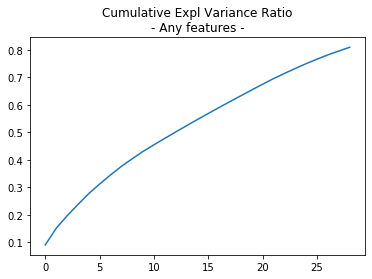

In [84]:
# cumulative expl variance ratio
plt.plot(np.cumsum(mypreprocessor['reducer']['pca'].explained_variance_ratio_))
plt.title('Cumulative Expl Variance Ratio\n- Any features -')

Text(0.5, 1.0, 'First 2 PCs projection\n- Any features -')

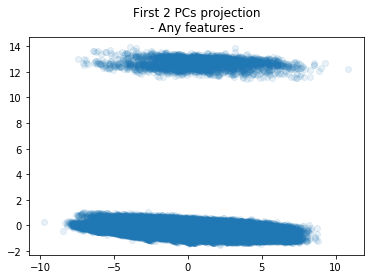

In [85]:
# data projection

plt.scatter(raw_data_reduced_df.iloc[:, 0],
            raw_data_reduced_df.iloc[:, 1],
            alpha=.1)
plt.title('First 2 PCs projection\n- Any features -')

(-0.5, 0.5)

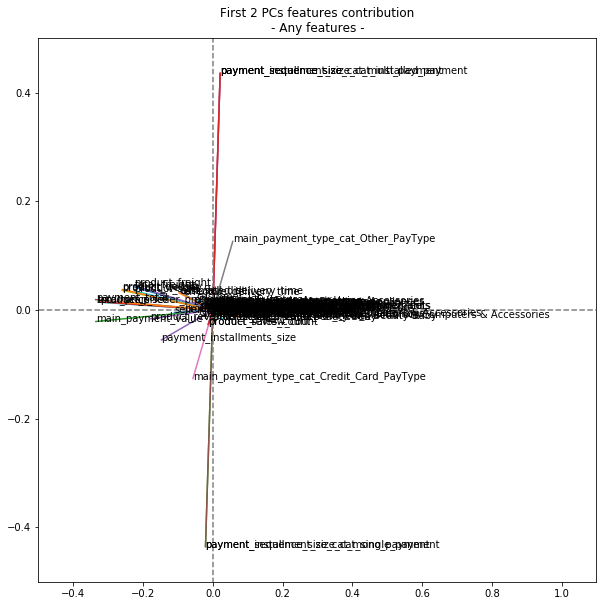

In [86]:
# features contribution to PC1 & PC2
# get back to raw_transformed_data to get names
pca_coordinates = mypreprocessor['reducer']['pca'].components_
fig = plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pca_coordinates[0, :], pca_coordinates[1, :])):
    plt.plot([0, x], [0, y])
    plt.text(x, y, raw_transformed_data.columns[i])
    plt.title('First 2 PCs features contribution\n- Any features -')
plt.plot([-1.1, 1.1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1.1, 1.1], color='grey', ls='--')
plt.xlim([-0.5, 1.1])
plt.ylim([-0.5, 0.5])

#### numerical features

In [93]:
# same for num only
raw_data_numerical_df = pd.DataFrame(
    myrawtransformer.fit_transform(raw_data_filtered),
    columns=raw_columns_names).filter(raw_numerical_features)

In [94]:
# apply reducer
raw_data_numerical_reduced_df = pd.DataFrame(mypreprocessor['reducer']['pca'].fit_transform(raw_data_numerical_df))

Text(0.5, 1.0, 'Cumulative Expl Variance Ratio\n- Numerical features -')

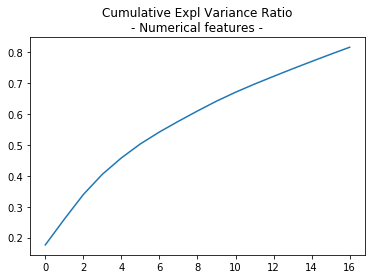

In [95]:
# cumulative expl variance ratio
plt.plot(np.cumsum(mypreprocessor['reducer']['pca'].explained_variance_ratio_))
plt.title('Cumulative Expl Variance Ratio\n- Numerical features -')

Text(0.5, 1.0, 'First 2 PCs projection\n- Numerical features -')

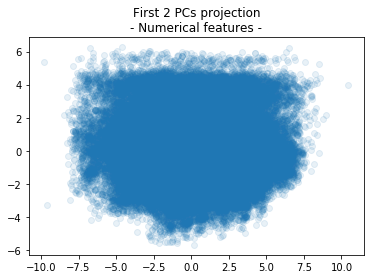

In [96]:
# projection
plt.scatter(raw_data_numerical_reduced_df.iloc[:, 0],
            raw_data_numerical_reduced_df.iloc[:, 1],
            alpha=.1)
plt.title('First 2 PCs projection\n- Numerical features -')

(-0.4, 0.6)

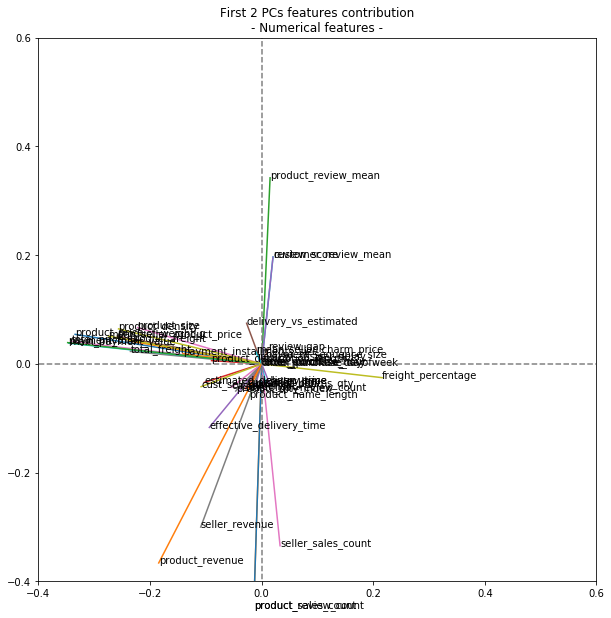

In [97]:
# features contribution to PC1 & PC2
pca_coordinates = mypreprocessor['reducer']['pca'].components_
fig = plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pca_coordinates[0, :], pca_coordinates[1, :])):
    plt.plot([0, x], [0, y])
    plt.text(x, y, raw_data_numerical_df.columns[i])
    plt.title('First 2 PCs features contribution\n- Numerical features -')
plt.plot([-1.1, 1.1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1.1, 1.1], color='grey', ls='--')
plt.xlim([-0.4, 0.6])
plt.ylim([-0.4, 0.6])

#### categorical features

In [103]:
# same for catégorical
raw_data_categorical_df = pd.DataFrame(
    myrawtransformer.fit_transform(raw_data_filtered),
    columns=raw_columns_names).filter(list(raw_categorical_labels))

In [104]:
# reduce
raw_data_categorical_reduced_df = pd.DataFrame(mypreprocessor['reducer']['pca'].fit_transform(raw_data_categorical_df))

Text(0.5, 1.0, 'Cumulative Expl Variance Ratio\n- Categorical features -')

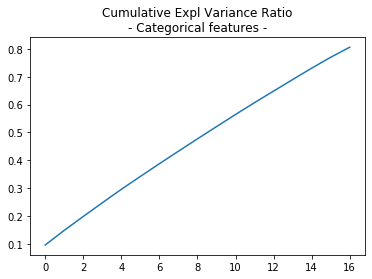

In [105]:
# cumulative expl variance ratio
plt.plot(np.cumsum(mypreprocessor['reducer']['pca'].explained_variance_ratio_))
plt.title('Cumulative Expl Variance Ratio\n- Categorical features -')

Text(0.5, 1.0, 'First 2 PCs projection\n- Categorical features -')

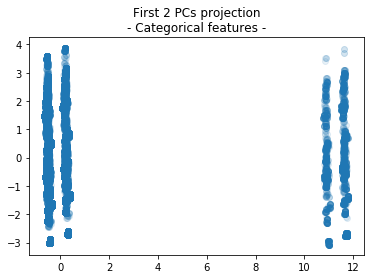

In [109]:
plt.scatter(raw_data_categorical_reduced_df.iloc[:, 0],
            raw_data_categorical_reduced_df.iloc[:, 1],
            alpha=.1)
plt.title('First 2 PCs projection\n- Categorical features -')

(-0.6, 0.6)

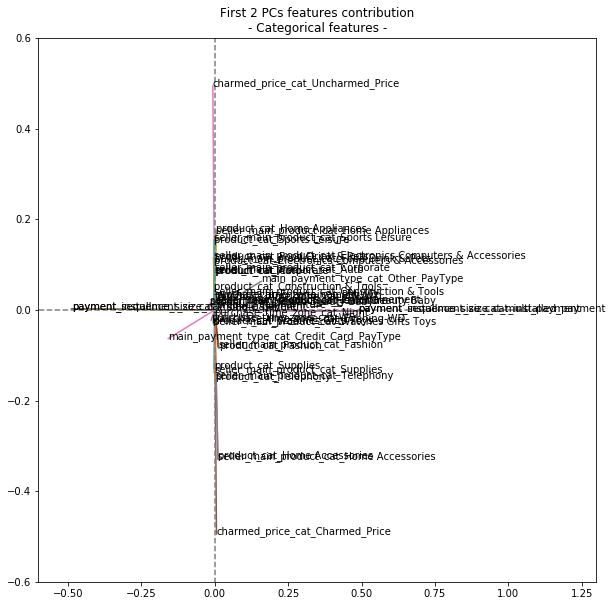

In [110]:
# features contribution to PC1 & PC2
pca_coordinates = mypreprocessor['reducer']['pca'].components_
fig = plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pca_coordinates[0, :], pca_coordinates[1, :])):
    plt.plot([0, x], [0, y])
    plt.text(x, y, list(categorical_labels)[i])
    plt.title('First 2 PCs features contribution\n- Categorical features -')
plt.plot([-1.1, 1.1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1.1, 1.1], color='grey', ls='--')
plt.xlim([-0.6, 1.3])
plt.ylim([-0.6, 0.6])

#### case of a shortlist

In [111]:
# get back to short_transformed_data and apply mydimreducer only
short_transformed_data_reduced_df = pd.DataFrame(mypreprocessor['reducer']['pca'].fit_transform(short_transformed_data))

Text(0.5, 1.0, 'Cumulative Expl Variance Ratio\n- Shortlisted features -')

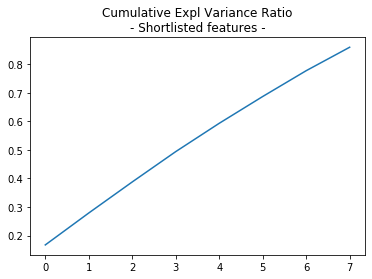

In [113]:
# cumulative expl variance ratio
plt.plot(np.cumsum(mypreprocessor['reducer']['pca'].explained_variance_ratio_))
plt.title('Cumulative Expl Variance Ratio\n- Shortlisted features -')

Text(0.5, 1.0, 'First 2 PCs projection\n- Shortlisted features -')

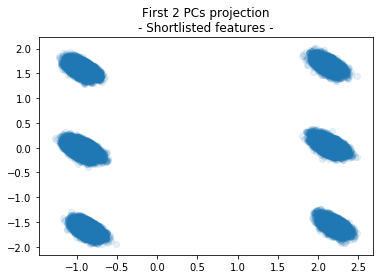

In [114]:
plt.scatter(short_transformed_data_reduced_df.iloc[:, 0],
            short_transformed_data_reduced_df.iloc[:, 1],
            alpha=.1)
plt.title('First 2 PCs projection\n- Shortlisted features -')

(-1, 1)

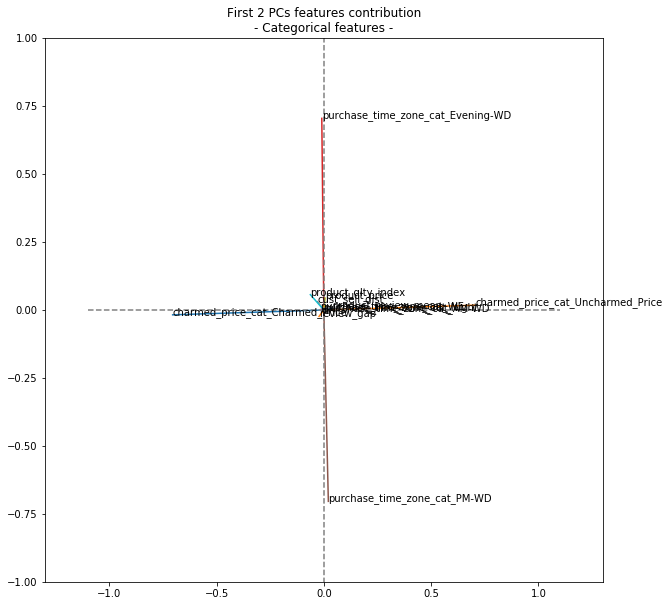

In [118]:
# features contribution to PC1 & PC2
pca_coordinates = mypreprocessor['reducer']['pca'].components_
fig = plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pca_coordinates[0, :], pca_coordinates[1, :])):
    plt.plot([0, x], [0, y])
    plt.text(x, y, short_transformed_data.columns[i])
    plt.title('First 2 PCs features contribution\n- Categorical features -')
plt.plot([-1.1, 1.1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1.1, 1.1], color='grey', ls='--')
plt.xlim([-1.3, 1.3])
plt.ylim([-1, 1])

### T-sne

Hyperparameters for t-SNE 
n_jobs number_cpus 
perplexity controls number of nearest-neighbors, use value between 5 and 50
early_exaggeration=12.0,  For larger values, the space between natural clusters will be larger in the embedded space.
learning_rate=200.0,  too high or too low: all datapoints will be bunched together.

In [ ]:
# because no fit_transform embedded, perform first mytransformer
raw_transformed_data = pd.DataFrame(myrawtransformer.transform(raw_data_filtered), columns=raw_columns_names)

In [ ]:
# because of the 

#### Any features

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(raw_transformed_data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 87086 samples in 64.479s...


Text(0.5, 1.0, 'First 2 T-sne dimensions\n- Any features -')

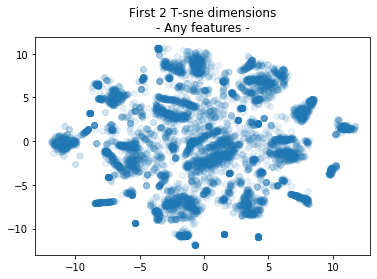

In [45]:
plt.scatter(tsne_results[:, 0],
            tsne_results[:, 1],
            alpha=.1)
plt.title('First 2 T-sne dimensions\n- Any features -')

#### Categorical features

In [74]:
data_categorical_df = transformed_data.filter(list(categorical_labels))

In [75]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_cat_results = tsne.fit_transform(data_categorical_df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8708 samples in 0.207s...
[t-SNE] Computed neighbors for 8708 samples in 5.825s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8708
[t-SNE] Computed conditional probabilities for sample 2000 / 8708
[t-SNE] Computed conditional probabilities for sample 3000 / 8708
[t-SNE] Computed conditional probabilities for sample 4000 / 8708
[t-SNE] Computed conditional probabilities for sample 5000 / 8708
[t-SNE] Computed conditional probabilities for sample 6000 / 8708
[t-SNE] Computed conditional probabilities for sample 7000 / 8708
[t-SNE] Computed conditional probabilities for sample 8000 / 8708
[t-SNE] Computed conditional probabilities for sample 8708 / 8708
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.798988
[t-SNE] KL divergence after 300 iterations: 1.640320
t-SNE done! Time elapsed: 30.874181747436523 seconds


Text(0.5, 1.0, 'First 2 T-sne dimensions\n- Any features -')

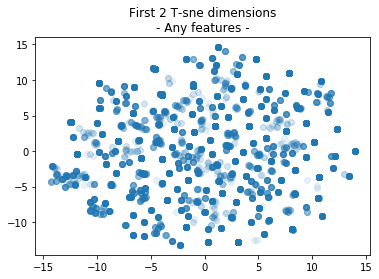

In [76]:
plt.scatter(tsne_cat_results[:, 0],
            tsne_cat_results[:, 1],
            alpha=.1)
plt.title('First 2 T-sne dimensions\n- Any features -')

#### numerical features

In [78]:
data_numerical_df = transformed_data.filter(list(numerical_features))

In [79]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_num_results = tsne.fit_transform(data_numerical_df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8708 samples in 0.110s...
[t-SNE] Computed neighbors for 8708 samples in 8.979s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8708
[t-SNE] Computed conditional probabilities for sample 2000 / 8708
[t-SNE] Computed conditional probabilities for sample 3000 / 8708
[t-SNE] Computed conditional probabilities for sample 4000 / 8708
[t-SNE] Computed conditional probabilities for sample 5000 / 8708
[t-SNE] Computed conditional probabilities for sample 6000 / 8708
[t-SNE] Computed conditional probabilities for sample 7000 / 8708
[t-SNE] Computed conditional probabilities for sample 8000 / 8708
[t-SNE] Computed conditional probabilities for sample 8708 / 8708
[t-SNE] Mean sigma: 1.899840
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.036865
[t-SNE] KL divergence after 300 iterations: 3.218936
t-SNE done! Time elapsed: 39.35605454444885 seconds


Text(0.5, 1.0, 'First 2 T-sne dimensions\n- Any features -')

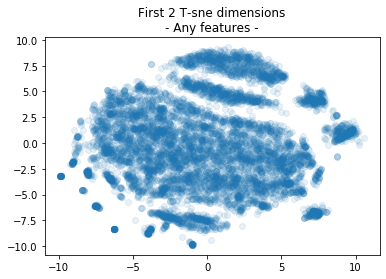

In [80]:
plt.scatter(tsne_num_results[:, 0],
            tsne_num_results[:, 1],
            alpha=.1)
plt.title('First 2 T-sne dimensions\n- Any features -')

In [84]:
# t-sne on data_test (subset of numerical)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_test_results = tsne.fit_transform(data_test)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8708 samples in 0.027s...
[t-SNE] Computed neighbors for 8708 samples in 0.702s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8708
[t-SNE] Computed conditional probabilities for sample 2000 / 8708
[t-SNE] Computed conditional probabilities for sample 3000 / 8708
[t-SNE] Computed conditional probabilities for sample 4000 / 8708
[t-SNE] Computed conditional probabilities for sample 5000 / 8708
[t-SNE] Computed conditional probabilities for sample 6000 / 8708
[t-SNE] Computed conditional probabilities for sample 7000 / 8708
[t-SNE] Computed conditional probabilities for sample 8000 / 8708
[t-SNE] Computed conditional probabilities for sample 8708 / 8708
[t-SNE] Mean sigma: 0.388684
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.667564
[t-SNE] KL divergence after 300 iterations: 2.683159
t-SNE done! Time elapsed: 32.660940170288086 seconds


Text(0.5, 1.0, 'First 2 T-sne dimensions\n- Any features -')

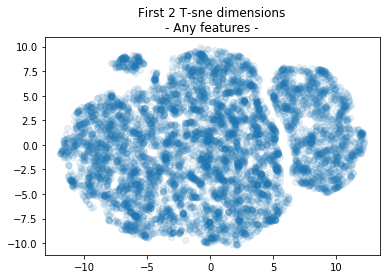

In [86]:
plt.scatter(tsne_test_results[:, 0],
            tsne_test_results[:, 1],
            alpha=.1)
plt.title('First 2 T-sne dimensions\n- Any features -')

#### UMAP

In [4]:
projector_umap = UMAP(random_state=42, 
    n_neighbors=15,  # balances local (low n_neighbors) vs global structure (high)
    min_dist=0.1,  # minimum distance apart that points are allowed to be in the representation. Use between 0 and 1
    n_components=2,  # Number of final dimensions
    metric="euclidean"  # how distance is computed in the ambient space of the input data
)

1:39: W291 trailing whitespace
2:5: E128 continuation line under-indented for visual indent
2:80: E501 line too long (82 > 79 characters)
3:5: E128 continuation line under-indented for visual indent
3:80: E501 line too long (116 > 79 characters)
4:5: E128 continuation line under-indented for visual indent
5:5: E128 continuation line under-indented for visual indent
5:80: E501 line too long (89 > 79 characters)
6:1: E124 closing bracket does not match visual indentation


In [27]:
time_start = time.time()
umap_results = projector_umap.fit_transform(transformed_data)
print('umap done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\etien\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


umap done! Time elapsed: 29.562337636947632 seconds


Text(0.5, 1.0, 'First 2 umap dimensions\n- Any features -')

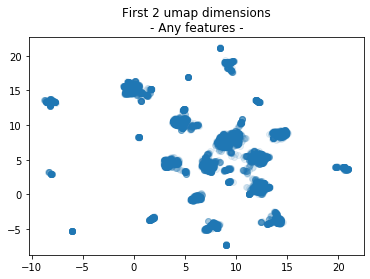

In [29]:
plt.scatter(umap_results[:, 0],
            umap_results[:, 1],
            alpha=.1)
plt.title('First 2 umap dimensions\n- Any features -')

# Cluster data

### define clusterer

In [50]:
# initialisation n_clusters
n_clusters = 5

In [51]:
# step de clusterisation
myclusterer = Pipeline(
    [
        ('kmeans', KMeans(n_clusters=n_clusters)),
        ('hclust', AgglomerativeClustering(n_clusters=n_clusters))
    ])

In [52]:
# définition du pipe 2 steps
mypipe = Pipeline(steps=[('preprocessor', mypreprocessor),
                         ('clusterer', myclusterer)])

mypipe shall be used for any feature study, and myclusterer only when focusing on categorical or numerical features, resp.  data_categorical_reduced_df and data_numerical_reduced_df.

## Test - Train split

In [100]:
mypipe.fit(data_sample)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('transformer',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore')),
                                                                                   ('scaler',
                                                                                    StandardScaler(with_mean=False))]),
                                                                   Index(['purchase_time_zone_cat', 'charmed_price_cat', 'product_cat',
       'payment_sequence_size_cat', 'payment_installment_size_cat',
       'main_paymen...
       'customer_review_mean', 'review_gap', 'seller_sales_count',
       'seller_revenue', 'mean_seller_product_price',
       'mean_seller_charm_price', 'product_sales_count', 'produ

### First Round

### preprocessor & check results

In [102]:
hclust_labels = mypipe['clusterer']['hclust'].fit_predict(transformed_data)

In [103]:
kmeans_labels = mypipe['clusterer']['kmeans'].fit_predict(transformed_data)

In [108]:
silhouette_score(transformed_data, hclust_labels)

0.04249035632406139

In [109]:
silhouette_score(transformed_data, kmeans_labels)

0.03898349729564884

### tunning both methods as a n_clusters function

In [110]:
# empty scores list
hclust_silhouette_scores = []
kmeans_silhouette_scores = []
hclust_davies_bouldin_score = []
kmeans_davies_bouldin_score = []

In [111]:
for n in range(2, 9):
    # This set the number of clusters,
    # but leaves other steps unchanged
    mypipe['clusterer'].n_clusters = n
    mypipe.fit(data_sample)

    preprocessed_data = mypipe['preprocessor'].transform(data_sample)
    hclust_labels = mypipe['clusterer']['hclust'].labels_
    kmeans_labels = mypipe['clusterer']['kmeans'].labels_

    hclust_silhouette = silhouette_score(preprocessed_data, hclust_labels)
    kmeans_silhouette = silhouette_score(preprocessed_data, kmeans_labels)

    hclust_davies_bouldin = davies_bouldin_score(preprocessed_data, hclust_labels)
    kmeans_davies_bouldin = davies_bouldin_score(preprocessed_data, kmeans_labels)

    # Add metrics to their lists
    hclust_silhouette_scores.append(hclust_silhouette)
    kmeans_silhouette_scores.append(kmeans_silhouette)

    hclust_davies_bouldin_score.append(hclust_davies_bouldin)
    kmeans_davies_bouldin_score.append(kmeans_davies_bouldin)



14:80: E501 line too long (82 > 79 characters)
15:80: E501 line too long (82 > 79 characters)


In [112]:
hclust_silhouette_scores

[0.04280350600070064,
 0.04280350600070064,
 0.04469858534635468,
 -0.011543708069129402,
 0.025916971606203956,
 -0.021799699531787262,
 0.030568654779422614]

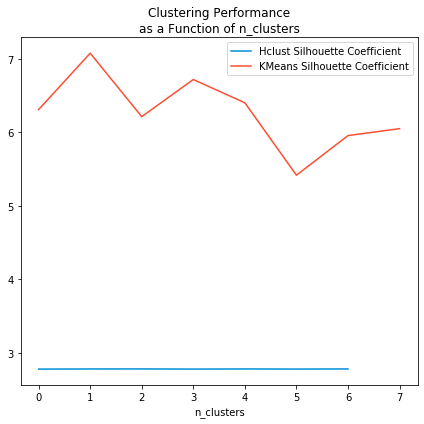

3:5: E128 continuation line under-indented for visual indent
4:5: E128 continuation line under-indented for visual indent
5:1: E124 closing bracket does not match visual indentation
7:5: E128 continuation line under-indented for visual indent
8:5: E128 continuation line under-indented for visual indent
9:1: E124 closing bracket does not match visual indentation


In [417]:
plt.figure(figsize=(6, 6))
plt.plot(kmeans_davies_bouldin_score,
    c="#008fd5",
    label="Hclust Silhouette Coefficient"
)
plt.plot(hclust_davies_bouldin_score,
    c="#fc4f30",
    label="KMeans Silhouette Coefficient"
)

plt.xlabel("n_clusters")
plt.legend()
plt.title("Clustering Performance\nas a Function of n_clusters")
plt.tight_layout()
plt.show()

### tuning PCA n_components
introducing PCA metric explained_variance_ratio

In [72]:
# empty scores list
hclust_silhouette_scores = []
kmeans_silhouette_scores = []
pca_explained_variance_ratios = []

In [73]:
for p in range(2, 5):
    # This set the number of PCA components,
    # but leaves other steps unchanged
    mypipe['preprocessor']['reducer']['pca'].n_components = p
    mypipe.fit(data_sample)

    pca_explained_variance = sum(mypipe['preprocessor']['reducer']['pca'].explained_variance_ratio_)
    preprocessed_data = mypipe['preprocessor'].transform(data_sample)
    

    hclust_silhouette_coef = silhouette_score(
        preprocessed_data,
        mypipe['clusterer']['hclust'].labels_
    )

    kmeans_silhouette_coef = silhouette_score(
        preprocessed_data,
        mypipe['clusterer']['kmeans'].labels_
    )

    # Add metrics to their lists
    hclust_silhouette_scores.append(hclust_silhouette_coef)
    kmeans_silhouette_scores.append(kmeans_silhouette_coef)
    pca_explained_variance_ratios.append(pca_explained_variance)


7:80: E501 line too long (100 > 79 characters)


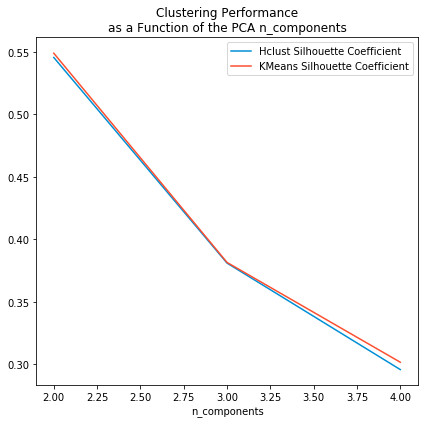

In [74]:
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 5),
    hclust_silhouette_scores,
    c="#008fd5",
    label="Hclust Silhouette Coefficient"
)
plt.plot(
    range(2, 5),
    kmeans_silhouette_scores,
    c="#fc4f30",
    label="KMeans Silhouette Coefficient"
)

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance\nas a Function of the PCA n_components")
plt.tight_layout()
plt.show()

In [75]:
pca_explained_variance_ratios

[0.15231911364787004, 0.19838954185644067, 0.2398253807942594]

## nested loops

In [77]:
# empty dfs
results = []

for n, p in product(range(1, 9), range(2, 5)):
    # This set
    # the n numbers of clusters
    # the p number of PCA components
    mypipe['preprocessor']['reducer']['pca'].n_components = p
    mypipe['clusterer'].n_clusters = n
    mypipe.fit(data_sample)
    preprocessed_data = mypipe['preprocessor'].transform(data_sample)

    hclust_silhouette_coef = silhouette_score(
        preprocessed_data,
        mypipe['clusterer']['hclust'].labels_
    )

    kmeans_silhouette_coef = silhouette_score(
        preprocessed_data,
        mypipe['clusterer']['kmeans'].labels_
    )

    # Add metrics to their lists
    results.append({'n': n,
                    'p': p,
                    'hclust_silhouette_coef': hclust_silhouette_coef,
                    'kmeans_silhouette_coef': kmeans_silhouette_coef})



In [78]:
df = pd.DataFrame(results)
print(df.iloc[df['kmeans_silhouette_coef'].idxmax()])
print(df.iloc[df['hclust_silhouette_coef'].idxmax()])

n                         1.000000
p                         2.000000
hclust_silhouette_coef    0.545277
kmeans_silhouette_coef    0.548819
Name: 0, dtype: float64
n                         2.000000
p                         2.000000
hclust_silhouette_coef    0.549398
kmeans_silhouette_coef    0.547979
Name: 3, dtype: float64


## 2-D scat plot in case of PCA n_components = 2 : emphasizing hclust & kmeans distinction

### with n_clusters = 2 for K-Means

In [43]:
# build a 2-D scatter plot
mypipe['preprocessor']['pca'].n_components = 2
mypipe['clusterer'].n_clusters = 2
mypipe
mypipe.fit(data_sample)

pcadf = pd.DataFrame(
    mypipe['preprocessor'].transform(data_sample),
    columns=['component_1', 'component_2'],
)

pcadf['hclust_cluster'] = mypipe['clusterer']['hclust'].labels_
pcadf['kmeans_cluster'] = mypipe['clusterer']['kmeans'].labels_

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


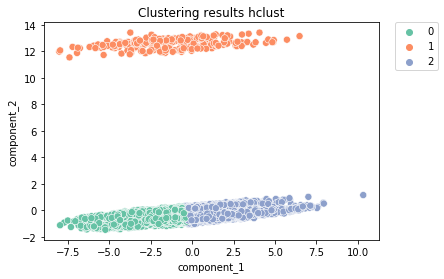

In [44]:
plt.scat = sns.scatterplot(
    'component_1',
    'component_2',
    s=50,
    data=pcadf,
    hue='hclust_cluster',
    palette='Set2')

plt.title(
    'Clustering results hclust')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


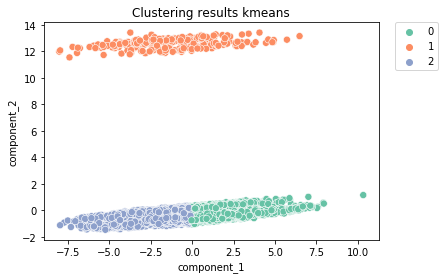

In [45]:
plt.scat = sns.scatterplot(
    'component_1',
    'component_2',
    s=50,
    data=pcadf,
    hue='kmeans_cluster',
    palette='Set2',
)
plt.title(
    'Clustering results kmeans'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## 3-D scat plot, case of PCA n_components = 3  & n_cluster = 6

In [46]:
# build a 3 components round
mypipe['preprocessor']['pca'].n_components = 3
mypipe['clusterer'].n_clusters = 6
mypipe.fit(data_sample)

pcadf = pd.DataFrame(
    mypipe['preprocessor'].transform(data_sample),
    columns=['component_1', 'component_2', 'component_3'],
)

pcadf['hclust_cluster'] = mypipe['clusterer']['hclust'].labels_
pcadf['kmeans_cluster'] = mypipe['clusterer']['kmeans'].labels_

In [47]:
# build a 3-D graph
mygraph = go.Figure()

for C in list(pcadf.hclust_cluster.unique()):
    mygraph.add_trace(
        go.Scatter3d(
            x=pcadf[pcadf.hclust_cluster == C]['component_1'],
            y=pcadf[pcadf.hclust_cluster == C]['component_2'],
            z=pcadf[pcadf.hclust_cluster == C]['component_3'],
            mode='markers',
            marker_size=2,
            marker_line_width=1,
            name='Cluster ' + str(C)))


mygraph.update_layout(width=800,
                      height=800,
                      autosize=True,
                      showlegend=True,
                      scene=dict(
                          xaxis=dict(title='component_1',
                                     titlefont_color='black'),
                          yaxis=dict(title='component_2',
                                     titlefont_color='black'),
                          zaxis=dict(title='component_3',
                                     titlefont_color='black')),
                      font=dict(family="Gilroy",
                                color='black',
                                size=12))


In [48]:
# build a 3-D graph
mygraph = go.Figure()

for C in list(pcadf.kmeans_cluster.unique()):
    mygraph.add_trace(
        go.Scatter3d(
            x=pcadf[pcadf.kmeans_cluster == C]['component_1'],
            y=pcadf[pcadf.kmeans_cluster == C]['component_2'],
            z=pcadf[pcadf.kmeans_cluster == C]['component_3'],
            mode='markers',
            marker_size=2,
            marker_line_width=1,
            name='Cluster ' + str(C)))


mygraph.update_layout(width=800,
                      height=800,
                      autosize=True,
                      showlegend=True,
                      scene=dict(
                          xaxis=dict(title='component_1',
                                     titlefont_color='black'),
                          yaxis=dict(title='component_2',
                                     titlefont_color='black'),
                          zaxis=dict(title='component_3',
                                     titlefont_color='black')),
                      font=dict(family="Gilroy",
                                color='black',
                                size=12))


# 3. K-Modes & K-Prototypes

### Refine "Categorical" features as input of K-Modes

K_modes est une technique de Clustering dédiée aux features catégoriels. Son principal intérêt dans ce projet serait de fournir une description sans équivoque des centroids et une caractéristation très simple des clusters ainsis formés. <br/>
La principale limitation est liée à notre contexte vient du fait qu'on considère comme catégories des features ordinaux : les features découpés en niveaux. L'algorythme trouvera la même différence, par exemple, entre below_median et over_median, qu'entre below median et median, tandis que dans les faits, il y a une progression ordonnée de below_median vers over_median. Cet inconvénient persiste avec la nature des features pris en compte, le "coût" d'une changement de catégorie étant le même quelque soit le feature.

Pour plus de détails sur cette approche :
- https://www.sciencedirect.com/science/article/pii/S1319157818300065 <br/>
- https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae <br/>

En résumé, il y a une forte dépendance aux centroids definis initialement, avec plusieurs techniques alternatives disponibles. La plus judicieuse dans notre contexte semble être "Cao" qui est déterministe en introduisant la notion de densité par rapport aux modes des features (fréquence maximale de chaque catégorie). <br/>
Il faut de nombreuses initialisations pour tomber sur la meilleure, et peu de clusters pour éviter qu'une trop grande dispersion n'empêche d'atteindre un optimum local.
De même on évitera de retenir des features avec une trop forte dispersion en catégories, pour lesquels il y a trop d'alternative au mode de la donnée.

evaluation : kmodes défini le cout, le moindre cout donnant le meilleur clustering

In [16]:
# https://github.com/nicodv/kmodes
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [17]:
# features candidat pour K-Modes : lvl & cat
level_features = data.columns[data.columns.str.contains('_lvl')]
print(level_features)
print(categorical_features)

Index(['delivery_vs_estimated_lvl', 'freight_percentage_lvl',
       'product_qlty_index_lvl', 'payment_lvl', 'product_price_lvl',
       'cust_sell_dist_lvl', 'review_answer_delay_lvl',
       'product_review_mean_lvl', 'review_gap_lvl'],
      dtype='object')
Index(['purchase_time_zone_cat', 'charmed_price_cat', 'product_cat',
       'payment_sequence_size_cat', 'payment_installment_size_cat',
       'main_payment_type_cat', 'seller_main_product_cat'],
      dtype='object')


In [18]:
# liste des features possibles pour KModes
kmodes_features_list = list(categorical_features)
kmodes_features_list.extend(list(level_features))
print(len(kmodes_features_list))

16


In [30]:
data_kmodes = data.filter(level_features)
data_kmodes.shape

(87086, 9)

In [31]:
# assert a first n_cluster number
# 'Cao' deterministic init computing feature modes
n_clusters = 1
km_test = KModes(n_clusters=n_clusters, init='Cao', n_init=1, verbose=1)
km_test.fit_predict(data_kmodes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 456268.0


array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [32]:
# centroids values
km_test.cluster_centroids_

array([['Later_Delivery', 'Low_FreightCost', 'High_QltyIdx',
        'Light_Payment', 'Light_Price', 'Near_Dist', 'Early_Answer',
        'Low_Score', 'Better_Review']], dtype='<U15')

In [25]:
# cost as a function of n_clusters
results = []
for n_clusters in range(1, 10):
    kmode = KModes(n_clusters=n_clusters, init="Cao", n_init=1, verbose=1)
    kmode.fit_predict(data_kmodes)
    results.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 722483.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9460, cost: 649682.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7073, cost: 612138.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7077, cost: 591464.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8376, cost: 574767.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1803, cost: 565112.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9785, cost: 547800.0
Run 1, iteration: 2/100, moves: 863, cost: 547800.0
Init: initializing c

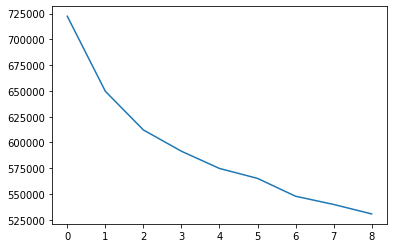

In [26]:
# pour 0=1 cluster à 8 -> 9 clusters
plt.plot(results)

In [67]:
# shortlist
kmodes_features_shortlist = ['cust_sell_dist_lvl',
                             'product_price_lvl',
                             'product_qlty_index_lvl',
                             'product_review_mean_lvl',
                             'review_gap_lvl',
                             'charmed_price_cat']

In [69]:
n_clusters = 1

In [70]:
km_test = KModes(n_clusters=n_clusters, init='Cao', n_init=1, verbose=1)

In [71]:
km_test.fit_predict(data_kmodes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 266712.0


array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [72]:
km_test.cluster_centroids_

array([['Near_Dist', 'Light_Price', 'High_QltyIdx', 'Low_Score',
        'Better_Review', 'Charmed_Price']], dtype='<U13')

In [81]:
kmode = KModes(n_clusters=3, init="Cao", n_init=1, verbose=1)
kmode.fit_predict(data_kmodes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8061, cost: 188913.0


array([0, 0, 2, ..., 0, 0, 0], dtype=uint16)

In [83]:
kmode.cluster_centroids_

array([['Near_Dist', 'Light_Price', 'High_QltyIdx', 'Low_Score',
        'Better_Review', 'Charmed_Price'],
       ['Far_Dist', 'Medium_Price', 'Low_QltyIdx', 'Top_Score',
        'Same_Review', 'Uncharmed_Price'],
       ['AroundMed_Dist', 'Light_Price', 'Low_QltyIdx', 'Medium_Score',
        'Worst_Review', 'Charmed_Price']], dtype='<U15')

In [84]:
data['kmodes_cluster'] = kmode.labels_

In [86]:
data['kmodes_cluster'].unique()

array([0, 2, 1], dtype=uint64)

Text(0.5, 1.02, 'kmodes clusters')

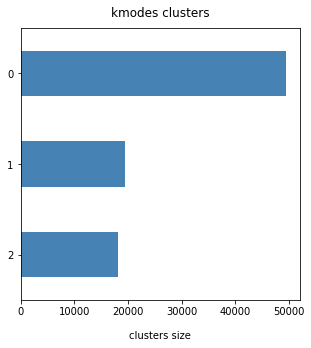

In [88]:
# observer la répartition des clusters
data['kmodes_cluster'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('clusters size', labelpad=14)
plt.title('kmodes clusters', y=1.02)

In [89]:
# original features
kmodes_features_shortlist_original = ['cust_sell_dist',
                                      'product_price',
                                      'product_qlty_index',
                                      'product_review_mean',
                                      'review_gap',
                                      'charmed_price']

In [90]:
kmodes_silhouette_coef = silhouette_score(
        data.filter(kmodes_features_shortlist_original),
        kmode.labels_
    )

In [91]:
kmodes_silhouette_coef

-0.019755326829860118

### non deterministic init method

In [96]:
list(range(10, 60, 20))

[10, 30, 50]

In [98]:
results = []
for n_clusters in range(2, 10):
    kmode = KModes(n_clusters=n_clusters, init="Huang", n_init=50, verbose=1)
    kmode.fit_predict(data_kmodes)
    results.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20004, cost: 209714.0
Run 1, iteration: 2/100, moves: 17091, cost: 209714.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 15438, cost: 210015.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 20318, cost: 225132.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 23782, cost: 208068.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 215126.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 14538, cost: 220518.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 15446, cost: 214505.0
Run 7, itera

Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 11284, cost: 194427.0
Run 6, iteration: 2/100, moves: 7358, cost: 194427.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 23629, cost: 190424.0
Run 7, iteration: 2/100, moves: 2856, cost: 190424.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration: 1/100, moves: 26473, cost: 185505.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 9, iteration: 1/100, moves: 14629, cost: 188897.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 10, iteration: 1/100, moves: 0, cost: 197204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 11, iteration: 1/100, moves: 12437, cost: 189470.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 12, iteration: 1/100, moves: 14841, c

Init: initializing clusters
Starting iterations...
Run 11, iteration: 1/100, moves: 16429, cost: 181890.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 12, iteration: 1/100, moves: 9553, cost: 187264.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 13, iteration: 1/100, moves: 12060, cost: 175955.0
Run 13, iteration: 2/100, moves: 6338, cost: 175955.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 14, iteration: 1/100, moves: 15239, cost: 176959.0
Run 14, iteration: 2/100, moves: 17212, cost: 176959.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 15, iteration: 1/100, moves: 5157, cost: 177584.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 16, iteration: 1/100, moves: 26842, cost: 171051.0
Run 16, iteration: 2/100, moves: 2129, cost: 171051.0
Init: initializing centroids
Init: initializing clusters
S

Run 14, iteration: 1/100, moves: 6425, cost: 175918.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 15, iteration: 1/100, moves: 7409, cost: 165218.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 16, iteration: 1/100, moves: 10374, cost: 176727.0
Run 16, iteration: 2/100, moves: 10176, cost: 176727.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 17, iteration: 1/100, moves: 0, cost: 162900.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 18, iteration: 1/100, moves: 9559, cost: 165960.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 19, iteration: 1/100, moves: 16907, cost: 170550.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 20, iteration: 1/100, moves: 13036, cost: 160955.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 21,

Run 16, iteration: 2/100, moves: 8723, cost: 152968.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 17, iteration: 1/100, moves: 6970, cost: 151641.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 18, iteration: 1/100, moves: 11969, cost: 165124.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 19, iteration: 1/100, moves: 0, cost: 156560.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 20, iteration: 1/100, moves: 0, cost: 160265.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 21, iteration: 1/100, moves: 29797, cost: 153089.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 22, iteration: 1/100, moves: 9939, cost: 154368.0
Run 22, iteration: 2/100, moves: 2731, cost: 154368.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 23, iter

Starting iterations...
Run 25, iteration: 1/100, moves: 23288, cost: 145606.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 26, iteration: 1/100, moves: 13291, cost: 147248.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 27, iteration: 1/100, moves: 15858, cost: 157389.0
Run 27, iteration: 2/100, moves: 8096, cost: 157389.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 28, iteration: 1/100, moves: 0, cost: 149943.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 29, iteration: 1/100, moves: 13069, cost: 151464.0
Run 29, iteration: 2/100, moves: 5683, cost: 151464.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 30, iteration: 1/100, moves: 16608, cost: 150127.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 31, iteration: 1/100, moves: 23853, cost: 153591.0
Init: in

Starting iterations...
Run 32, iteration: 1/100, moves: 20740, cost: 158715.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 33, iteration: 1/100, moves: 4192, cost: 151258.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 34, iteration: 1/100, moves: 8694, cost: 156581.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 35, iteration: 1/100, moves: 4060, cost: 142385.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 36, iteration: 1/100, moves: 0, cost: 147411.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 37, iteration: 1/100, moves: 5993, cost: 142378.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 38, iteration: 1/100, moves: 12328, cost: 148304.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 39, iteration: 1/100, moves: 23415, 

Init: initializing clusters
Starting iterations...
Run 42, iteration: 1/100, moves: 6743, cost: 144308.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 43, iteration: 1/100, moves: 8408, cost: 140599.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 44, iteration: 1/100, moves: 0, cost: 135262.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 45, iteration: 1/100, moves: 19597, cost: 136256.0
Run 45, iteration: 2/100, moves: 2231, cost: 136256.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 46, iteration: 1/100, moves: 8185, cost: 134756.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 47, iteration: 1/100, moves: 4513, cost: 140349.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 48, iteration: 1/100, moves: 5114, cost: 138041.0
Init: initializing centroids
Init: init

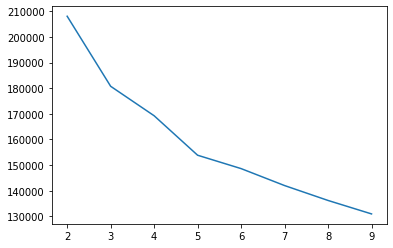

1:33: E231 missing whitespace after ','


In [100]:
y = np.array([i for i in range(2, 10)])
plt.plot(y, results)

2 : Best run was number 4 <br/>
3 : Best run was number 19 <br/>
4 : Best run was number 17 <br/>
5 : Best run was number 33 <br/>
6 : Best run was number 31 <br/>
7 : Best run was number 5 <br/>
8 : Best run was number 45 <br/>
9 : Best run was number 40 <br/>
with only 90 2nd iteration and 6 3rd iteration  

In [ ]:
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=2)
clusters = kproto.fit_predict(df_1, categorical=[2,3,4,6,7,8,12,14,15,16])


# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)
# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

In [ ]:
for i in range(num_of_clusters):
  print("\nCentroid:",i+1,"\n\n\t\t(Numeric)\t\t\t\t\t\t(Categorical)\n")
  print(list(np.rint(np.around(kproto.cluster_centroids_[0][i],1))), end=' ')
  print(list(np.rint(np.around(kproto.cluster_centroids_[1][i],1))))